# Predicting Price Of Renting An Apartment In Lagos State.

The objective of this project is predicting the cost of renting an apartment in lagos state based on the area, number of bed rooms and number of toilets.
Data set for this project was gathered from https://tolet.ng, also scrapper for gathered the data can be found on my github here -> https://github.com/victorlenerd/toletngscrapper.

## Loading And Cleaning Data.

In [1]:
## Loading Data
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as sm
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
import math

%matplotlib inline

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_json('./data.json')
data.tail()

,area,no_bath,no_bed,no_toilets,price
9041,"Mafoluku road, Isolo, Mafoluku Oshodi Lagos",1,1,1,280000.0
9042,"Mafoluku road, Mafoluku Oshodi Lagos",1,1,1,280000.0
9043,,0,0,0,NaN
9044,,0,0,0,NaN
9045,,0,0,0,NaN


In [3]:
data.describe()

,no_bath,no_bed,no_toilets,price
count,9046.000000,9046.000000,9046.000000,7.846000e+03
mean,2.125138,2.170462,2.404378,3.302896e+06
std,1.588876,1.581791,1.889390,4.822354e+07
min,0.000000,0.000000,0.000000,1.000000e-02
25%,1.000000,1.000000,1.000000,5.000000e+05
50%,2.000000,2.000000,3.000000,1.000000e+06
75%,3.000000,3.000000,4.000000,2.875000e+06
max,10.000000,10.000000,10.000000,4.000000e+09


In [4]:
# The scrapper gathered some wrong values from dom elements that had the same property. It's best to drop them
data = data.dropna()

In [5]:
data.describe()

,no_bath,no_bed,no_toilets,price
count,7846.000000,7846.000000,7846.000000,7.846000e+03
mean,2.450166,2.502422,2.772113,3.302896e+06
std,1.454034,1.433170,1.759633,4.822354e+07
min,0.000000,0.000000,0.000000,1.000000e-02
25%,1.000000,1.000000,1.000000,5.000000e+05
50%,3.000000,3.000000,3.000000,1.000000e+06
75%,3.000000,3.000000,4.000000,2.875000e+06
max,10.000000,10.000000,10.000000,4.000000e+09


In [6]:
data.tail()

,area,no_bath,no_bed,no_toilets,price
9038,- Abule Egba Abule Egba Lagos,2,2,3,500000.0
9039,- Lekki Phase 1 Lekki Lagos,5,5,6,5500000.0
9040,"Awuse Estate, Opebi, Lagos Opebi Ikeja Lagos",5,5,6,2500000.0
9041,"Mafoluku road, Isolo, Mafoluku Oshodi Lagos",1,1,1,280000.0
9042,"Mafoluku road, Mafoluku Oshodi Lagos",1,1,1,280000.0


### Using areas.json to make area property more structured, by converting address to area.

In [7]:
## Loading Areas
areas = pd.read_json('./areas.json')

In [8]:
areas_dict = areas.to_dict()
areas_list = []

for key, value in areas_dict[0].items():
    areas_list.append(value)
    
print(areas_list)

['Abule Egba', 'Agege', 'Ajah', 'Ajaokuta', 'Alimosho', 'Amuwo Odofin', 'Apapa', 'Arepo', 'Badagry', 'Egbe Idimu', 'Egbeda', 'Ejigbo', 'Epe', 'Gbagada', 'Ibeju Lekki', 'Iju', 'Ikeja', 'Ikorodu', 'Ikotun Igando', 'Ikoyi', 'Ilaje', 'Ilupeju', 'Ipaja', 'Isolo', 'Ketu', 'Kosofe Ikosi', 'Lagos Island', 'Lekki', 'Maryland', 'Mushin', 'Ogba', 'Ogudu', 'Ojo', 'Ojodu', 'Ojota', 'Okota', 'Orile', 'Oshodi', 'Sangotedo', 'Shagari', 'Shomolu', 'Surulere', 'Victoria Island', 'Yaba']


In [9]:
def addressToArea(address):
    
    address = address.replace(',', '')
    address = address.replace('-', '')
    address = address.replace('/', ' ')
    
    for area in areas_list:
        if area.lower() in address.lower():
            return area
    
    # Fix bad addresses
    
    if 'greenville' in address.lower():
        return 'Ajah'
    
    if  'southen' in address.lower() or 'oral' in address.lower() or 'crest' in address.lower() or 'osborne' in address.lower() or 'agungi' in address.lower() or  'lekky' in address.lower() or 'admiralty' in address.lower() or 'ikota' in address.lower() or 'ikate' in address.lower() or 'chevron' in address.lower() or 'chevy' in address.lower() or 'shoprite' in address.lower() or 'osapa' in address.lower() or 'parkview' in address.lower():
        return 'Lekki'
    
    if 'mende'in address.lower() or 'aladura' in address.lower() or 'olatunde sanni'  in address.lower():
        return 'Maryland'

    if 'alakuko' in address.lower() or 'saji ayangade' in address.lower():
        return 'Ikeja'
    
    if 'ishaga' in address.lower():
        return 'Isolo'

    if 'oniru' in address.lower() or 'banana island' in address.lower():
        return 'Ikoyi'
    
    if 'alaka' in address.lower() or 'adekunle' in address.lower() or 'james island' in address.lower():
        return 'Surulere'
    
    if 'block d5' in address.lower():
        return 'Victoria Island'
    
    print ('Cound not find address', address)
    return address

In [10]:
data['area'] = data['area'].apply(addressToArea)

In [11]:
# Remove entries with less than one bed rooms
data = data[data['no_bed'] > 1]

In [12]:
data.describe()

,no_bath,no_bed,no_toilets,price
count,5866.000000,5866.000000,5866.000000,5.866000e+03
mean,3.018411,3.125298,3.396693,3.491016e+06
std,1.193333,1.064734,1.494171,5.241682e+07
min,0.000000,2.000000,0.000000,1.000000e+00
25%,2.000000,2.000000,3.000000,7.000000e+05
50%,3.000000,3.000000,3.000000,1.500000e+06
75%,4.000000,4.000000,4.000000,3.300000e+06
max,10.000000,10.000000,10.000000,4.000000e+09


### Visualizing Data

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111a9e588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11192ab38>]], dtype=object)

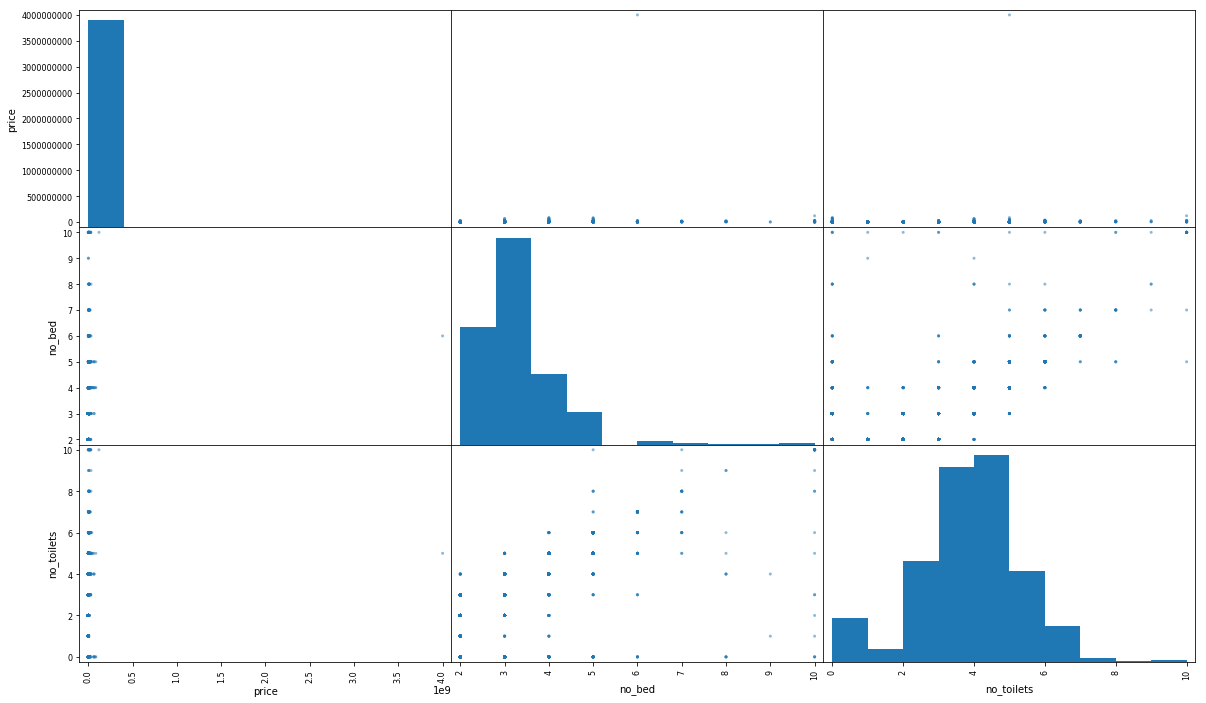

In [13]:
attributes = ['price', 'no_bed', 'no_toilets']

scatter_matrix(data[attributes], figsize=(20, 12))

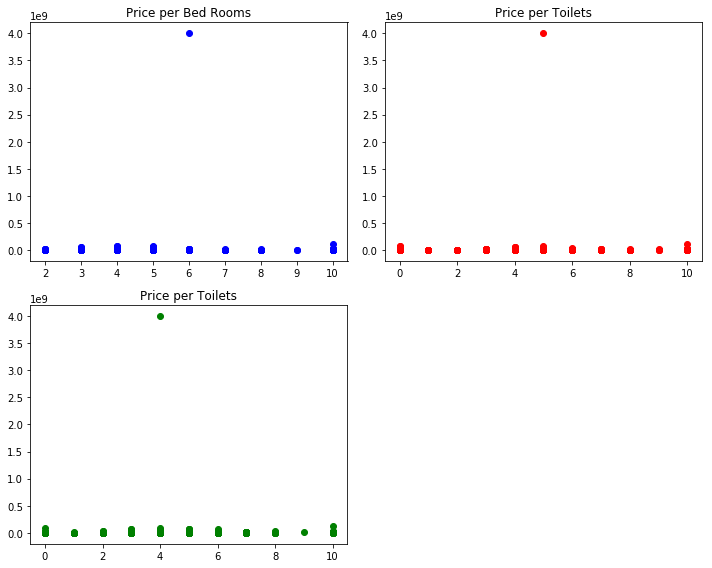

In [45]:
plt.figure(figsize=(10,8))

plt.subplot(2, 2, 1)
plt.scatter(data['no_bed'], data['price'], color='blue')
plt.title('Price per Bed Rooms')

plt.subplot(2, 2, 2)
plt.scatter(data['no_toilets'], data['price'], color='red')
plt.title('Price per Toilets')

plt.subplot(2, 2, 3)
plt.scatter(data['no_bath'], data['price'], color='green')
plt.title('Price per Toilets')

plt.tight_layout()
plt.show()

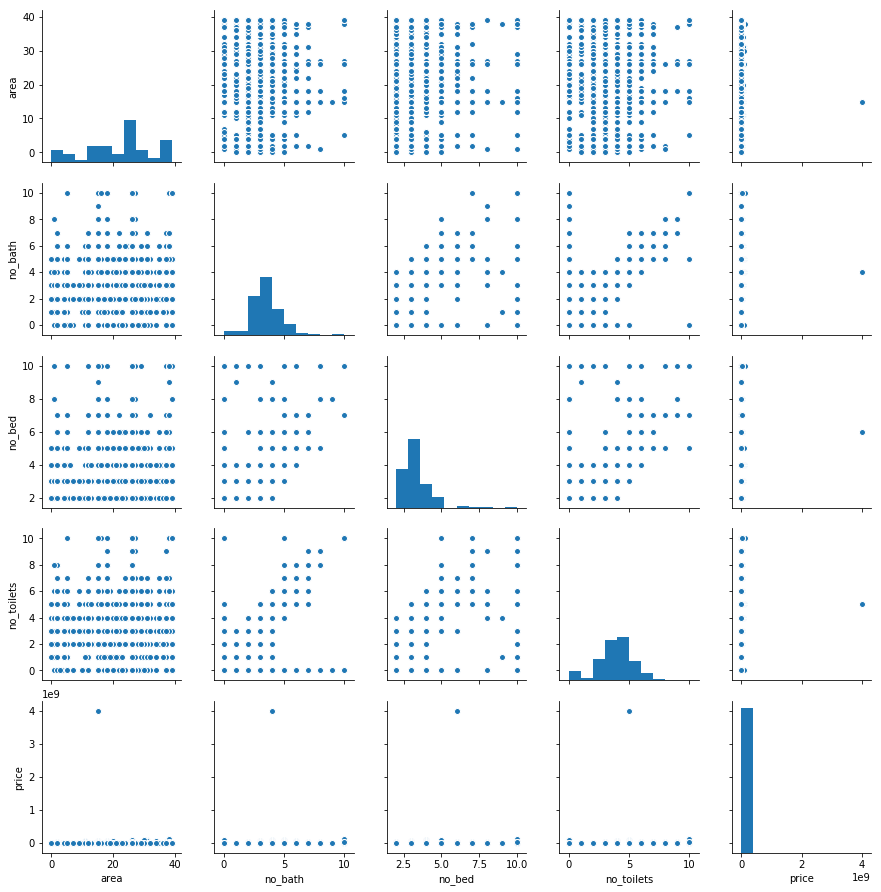

In [83]:
sns.pairplot(data)

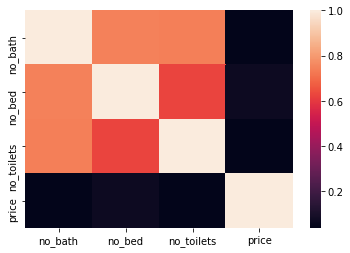

In [22]:
sns.heatmap(data.corr())

### Convert Area To Numerical Values

In [23]:
encoder = LabelEncoder()
housing_areas = data['area']
housing_area_endcoded = encoder.fit_transform(housing_areas)
data['area'] = housing_area_endcoded

In [24]:
encoder.classes_

array(['Abule Egba', 'Agege', 'Ajah', 'Ajaokuta', 'Alimosho',
       'Amuwo Odofin', 'Apapa', 'Arepo', 'Badagry', 'Egbe Idimu', 'Ejigbo',
       'Epe', 'Gbagada', 'Ibeju Lekki', 'Iju', 'Ikeja', 'Ikorodu',
       'Ikotun Igando', 'Ikoyi', 'Ilaje', 'Ilupeju', 'Ipaja', 'Isolo',
       'Ketu', 'Kosofe Ikosi', 'Lagos Island', 'Lekki', 'Maryland',
       'Mushin', 'Ogba', 'Ogudu', 'Ojo', 'Okota', 'Orile', 'Oshodi',
       'Sangotedo', 'Shomolu', 'Surulere', 'Victoria Island', 'Yaba'], dtype=object)

In [25]:
data.head()

,area,no_bath,no_bed,no_toilets,price
0,2,3,3,4,1200000.0
6,26,5,5,5,4000000.0
8,21,2,2,0,200000.0
9,21,3,3,0,5500000.0
10,38,3,3,4,18000000.0


# Model Development

The accuracy of the model used would be measured using: 
   * **Mean Squared Error**: This is the average of the squares of the errors of all the datapoints in the given dataset.
   * **Explained Variance Score**: This score measures how well our model can account for the variation in our dataset.
   * **R2-score**: This tells us how well the unknown samples will be predicted by our model.

In [26]:
def accuracy(test, pred):
    print("Mean Squared Error: ", round(sm.mean_squared_error(test, pred), 2))
    print("Explained Variance Score: ", round(sm.explained_variance_score(test, pred),2))
    print("R2-score: ", round(sm.r2_score(test, pred), 2))

## Spliting data for train and test

In [76]:
price = pd.Series(data['price'], dtype='float32')
feature_final = data.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feature_final,
                                                    price,
                                                   test_size = 0.2,
                                                   random_state = 0)

In [77]:
print("Training set has {} samples.", X_train.shape)
print("Testing set has {} samples.", y_train.shape)

Training set has {} samples. (4692, 4)
Testing set has {} samples. (4692,)


### Base Model Performance

In [78]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [79]:
y_train_pred = linear_regressor.predict(X_train)

In [80]:
accuracy(y_train, y_train_pred)

Mean Squared Error:  3.41036835367e+15
Explained Variance Score:  0.01
R2-score:  0.01


ValueError: x and y must be the same size

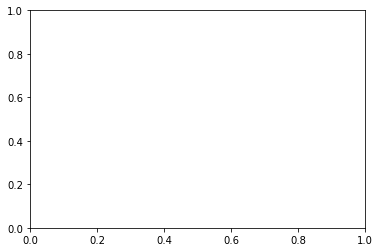

In [82]:
plt.scatter(X_train, y_train)
plt.plot(X_train, y_train_pred, color='black', linewidth=4)
plt.title('Training Data')
plt.show()